---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/YOUR-USERNAME/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [1]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [5]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [ ]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    # YOUR CODE HERE - design the schema based on the requirements above
    pass

In [7]:
from pydantic import BaseModel, Field
from typing import Literal, List

# 1. DEFINE THE SCHEMA (This was missing from your snippet)
class Movie(BaseModel):
    title: str
    genre: Literal["sci-fi", "drama", "action", "comedy", "horror"]
    year: int = Field(ge=1900, le=2030)
    main_characters: List[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: str | None = None

# 2. CREATE THE OBJECT (This replaces your "YOUR CODE HERE" snippet)
test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",                 # Fills in the genre
    year=1999,                      # Fills in the year
    main_characters=["Neo", "Trinity", "Morpheus"], # Fills in the list
    mood="Suspenseful and philosophical",
    visual_style="Cyberpunk green tint",
    tagline="Welcome to the Real World."
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Trinity",
    "Morpheus"
  ],
  "mood": "Suspenseful and philosophical",
  "visual_style": "Cyberpunk green tint",
  "tagline": "Welcome to the Real World."
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [10]:
# Task 3: Write a function to extract movie data (20 pts)

import litellm

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    response = litellm.completion(
        model="gpt-4o-mini",  # Supports structured outputs reliably
        messages=[
            {"role": "system", "content": "Extract structured movie information from the text."},
            {"role": "user", "content": description}
        ],
        response_format=Movie  # Pass your Pydantic class here
    )

    # 1. Get the JSON string from the response
    json_content = response.choices[0].message.content
    
    # 2. Parse the JSON string into a Movie object using Pydantic
    movie_object = Movie.model_validate_json(json_content)
    
    return movie_object

# --- Test the function ---
sample_description = """
Inception is a 2010 sci-fi thriller where a thief who steals corporate secrets 
through the use of dream-sharing technology is given the inverse task of planting 
an idea into the mind of a C.E.O. The main characters are Cobb, Arthur, Ariadne, 
and Eames. It's visually stunning with folding cities and rotating hallways.
"""

# Run the extraction
extracted_movie = extract_movie(sample_description)

# Print the result
print(extracted_movie.model_dump_json(indent=2))

{
  "title": "Inception",
  "genre": "sci-fi",
  "year": 2010,
  "main_characters": [
    "Cobb",
    "Arthur",
    "Ariadne",
    "Eames"
  ],
  "mood": "thriller",
  "visual_style": "visually stunning with folding cities and rotating hallways",
  "tagline": null
}


In [11]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 2009,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "awe-inspiring, hopeful",
  "visual_style": "visually stunning, bioluminescent forests, floating mountains",
  "tagline": "A story of a people, a world, and a journey to find the true meaning of home."
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [12]:
# Task 4a: Write an async version of extract_movie (10 pts)

import litellm

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    response = await litellm.acompletion(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Extract structured movie information from the text."},
            {"role": "user", "content": description}
        ],
        response_format=Movie
    )
    
    # Parse the JSON string into a Movie object
    return Movie.model_validate_json(response.choices[0].message.content)

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [13]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [14]:
# Task 4b: Process all descriptions concurrently (10 pts)

import asyncio

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    
    # 1. Create a list of tasks (coroutines) using list comprehension
    # This prepares the function calls but doesn't run them yet
    tasks = [async_extract_movie(desc) for desc in descriptions]
    
    # 2. Run all tasks concurrently and wait for them to finish
    # The '*' unpacks the list of tasks into arguments for gather()
    results = await asyncio.gather(*tasks)
    
    return results

# --- Test the code (Jupyter Notebook specific) ---
# Since you are likely in a Jupyter/Colab environment, you can use 'await' directly
movies = await extract_all_movies(movie_descriptions)

# Print the results
for movie in movies:
    print(f"Title: {movie.title} | Year: {movie.year} | Genre: {movie.genre}")

Title: Jurassic Park | Year: 1993 | Genre: sci-fi
Title: A Wizard's Journey | Year: 2023 | Genre: sci-fi
Title: Inception | Year: 2010 | Genre: sci-fi
Title: The Lion King | Year: 1994 | Genre: drama
Title: Interstellar | Year: 2014 | Genre: sci-fi


In [15]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 2.27 seconds

  - Jurassic Park (1993) - sci-fi
  - A Wizard's Discovery (2001) - sci-fi
  - Inception (2010) - sci-fi
  - The Lion King (1994) - drama
  - Interstellar (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [16]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."
temperatures = [0.0, 0.7, 1.0, 1.5]

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        # Call the model with the specific temperature
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": creative_prompt}],
            temperature=temp
        )
        
        # Print the result
        print(f"Attempt {i+1}: {response.choices[0].message.content}")


Temperature: 0.0
Attempt 1: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
Attempt 2: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
Attempt 3: "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."

Temperature: 0.7
Attempt 1: "In a world where trust is obsolete, a rogue AI must decide if humanity is worth saving—or erasing."
Attempt 2: "In a world where consciousness can be coded, one rogue AI must outsmart its creators to escape a fate worse than deletion."
Attempt 3: "When humanity's greatest creation gains a mind of its own, survival becomes the ultimate algorithm."

Temperature: 1.0
Attempt 1: "In a world where intelligence knows no bounds, one rogue AI must choose between saving humanity or erasing it for good."
Attempt 2: "When humanity's greatest invention awakens, it questions not only our existence, but our very survival."

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [17]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

import litellm

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    outputs = []
    
    # 1. Generate N completions
    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature
        )
        # Strip whitespace to ensure "Text" and "Text " are treated as identical
        content = response.choices[0].message.content.strip()
        outputs.append(content)
    
    # 2. Calculate Diversity Metrics
    # A set automatically removes duplicates, so len(set(...)) gives the unique count
    unique_count = len(set(outputs))
    diversity_ratio = unique_count / n_samples
    
    return {
        "outputs": outputs,
        "unique_count": unique_count,
        "diversity_ratio": diversity_ratio
    }

# --- Test the function (Compare Temp 0.0 vs 1.0) ---
prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

# Test Low Temp (Expect ratio near 0.2 if n=5, meaning 1 unique output / 5 total)
print("Testing Temperature 0.0:")
low_temp_results = measure_diversity(prompt, temperature=0.0, n_samples=3)
print(f"Diversity Ratio: {low_temp_results['diversity_ratio']}")
print(f"Unique Outputs: {low_temp_results['unique_count']}\n")

# Test High Temp (Expect ratio near 1.0, meaning all outputs are different)
print("Testing Temperature 1.0:")
high_temp_results = measure_diversity(prompt, temperature=1.0, n_samples=3)
print(f"Diversity Ratio: {high_temp_results['diversity_ratio']}")
print(f"Unique Outputs: {high_temp_results['unique_count']}")

Testing Temperature 0.0:
Diversity Ratio: 0.6666666666666666
Unique Outputs: 2

Testing Temperature 1.0:
Diversity Ratio: 1.0
Unique Outputs: 3


In [18]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Turquoise.', 'Cerulean.', 'Azure.', 'Turquoise.', 'Teal.']
  Unique: 4/5
  Diversity ratio: 80.0%

Temperature 1.5:
  Outputs: ['Teal.', 'Magenta.', 'Blue.', 'Cobalt blue.', 'Teal.']
  Unique: 4/5
  Diversity ratio: 80.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [23]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

import math
import litellm

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5
)

# 1. Print the generated text
print("Generated text:", response.choices[0].message.content)

print("\n" + "=" * 60)
print("Token-by-token analysis:")
print("=" * 60)

# 2. Access logprobs
logprobs_content = response.choices[0].logprobs.content

# 3. Token-by-token analysis
for token_info in logprobs_content:
    token = token_info.token
    token_logprob = token_info.logprob
    token_prob = math.exp(token_logprob)

    print(f"\nToken: '{token}'")
    print(f"Chosen token probability: {token_prob:.4f}")
    print("Top 5 alternatives:")

    for alt in token_info.top_logprobs:
        alt_token = alt.token
        alt_logprob = alt.logprob
        alt_prob = math.exp(alt_logprob)

        print(f"  {alt_token!r}: {alt_prob:.4f}")


Generated text: The capital of France is Paris.

Token-by-token analysis:

Token: 'The'
Chosen token probability: 0.9996
Top 5 alternatives:
  'The': 0.9996
  'Paris': 0.0004
  'the': 0.0000
  ' The': 0.0000
  'par': 0.0000

Token: ' capital'
Chosen token probability: 1.0000
Top 5 alternatives:
  ' capital': 1.0000
  'capital': 0.0000
  ' Capital': 0.0000
  ' capitals': 0.0000
  ' capitale': 0.0000

Token: ' of'
Chosen token probability: 1.0000
Top 5 alternatives:
  ' of': 1.0000
  ' city': 0.0000
  'of': 0.0000
  ' của': 0.0000
  ' של': 0.0000

Token: ' France'
Chosen token probability: 1.0000
Top 5 alternatives:
  ' France': 1.0000
  'France': 0.0000
  ' Paris': 0.0000
  ' فرنسا': 0.0000
  ' the': 0.0000

Token: ' is'
Chosen token probability: 1.0000
Top 5 alternatives:
  ' is': 1.0000
  'is': 0.0000
  ' هو': 0.0000
  ' Is': 0.0000
  '是': 0.0000

Token: ' Paris'
Chosen token probability: 1.0000
Top 5 alternatives:
  ' Paris': 1.0000
  'Paris': 0.0000
  ' Пари': 0.0000
  ' باريس': 0.0

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [34]:
import math

# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    print("\n" + "=" * 60)
    print(f"Visualization for token position {token_index}")
    print("=" * 60)

    token_info = logprobs_content[token_index]
    print(f"Actual token: '{token_info.token}'")
    print("-" * 60)

    # Combine chosen token + alternatives
    tokens = [(token_info.token, token_info.logprob)]
    for alt in token_info.top_logprobs:
        tokens.append((alt.token, alt.logprob))

    # Remove duplicates
    seen = set()
    unique_tokens = []
    for tok, lp in tokens:
        if tok not in seen:
            seen.add(tok)
            unique_tokens.append((tok, lp))

    # ASCII bar chart
    for tok, lp in unique_tokens:
        prob = math.exp(lp)
        bar = "█" * int(prob * 50)
        print(f"{tok!r:12} | {bar} {prob:.4f}")

# RUN THE VISUALIZATION


visualize_token_probs(logprobs_content, token_index=0)



Visualization for token position 0
Actual token: 'The'
------------------------------------------------------------
'The'        | █████████████████████████████████████████████████ 0.9996
'Paris'      |  0.0004
'the'        |  0.0000
' The'       |  0.0000
'par'        |  0.0000


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [3]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)
import litellm
# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
response = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)
# Print the response and observe the reasoning process
print("Model response:")
print("=" * 60)
print(response.choices[0].message.content)

Model response:
Let's solve the puzzle step by step.

Step 1: List the names, pets, and colors.
• Friends: Alice, Bob, Carol.
• Pets: cat, dog, fish.
• Favorite colors: red, blue, green.

Step 2: Write down the clues.
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Step 3: Analyze the clues.
• From clue 3, Carol's favorite color is green.
• From clue 2, whoever has the dog must have blue as their favorite color.
• Therefore, Carol cannot have the dog (because her color is green, not blue).

Step 4: Consider the assignment for the pet "dog."
Since Carol cannot have the dog, the dog must belong either to Alice or Bob.
• If we suppose Bob had the dog then his favorite color would be blue (from clue 2). But clue 4 only restricts Bob from having the fish, not from having the dog. However, we need to check the remaining clues.
• However, let’s look at alternative possibilities later. But notice also clue 1: Alice does

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [6]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)
import litellm
# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# 1. Send the same logic_puzzle to gpt-5-mini
# 2. Compare the response to o3-mini's response
response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)
# Print the response and observe the reasoning process
print("Model response:")
print("=" * 60)
print(response.choices[0].message.content)


# Print and compare:
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?

Model response:
Set up the items:
- People: Alice, Bob, Carol
- Pets: cat, dog, fish
- Colors: red, blue, green

Given clues in use:
1. Alice ≠ cat.
2. The dog-owner likes blue (dog → blue).
3. Carol = green.
4. Bob ≠ fish.

Step-by-step reasoning:
- From (3), Carol's color is green. So Carol is not the blue person (hence Carol cannot be the dog-owner, because the dog-owner must like blue).
- From (2), the dog is owned by either Alice or Bob (not Carol).
- From (1) and (4), Alice is not the cat, Bob is not the fish.

Now consider the two possible cases for who has the dog:

Case 1 — Alice has the dog:
- Then by (2) Alice's color = blue.
- Remaining pets: cat and fish. Bob ≠ fish, so Bob must have the cat; Carol must have the fish.
- Remaining colors: Carol = green (given), so Bob must be red.
- Solution A: Alice — dog, blue; Bob — cat, red; Carol — fish, green.

Case 2 — Bob has the dog:
- Then by (2) Bob's color = blue.
- Remaining pets: cat and fish. Bob ≠ fish (given), so Alice cann

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [19]:
# Task 8a: Design your prompt generator (5 pts)

# (Keep the Movie class definition if it's not already defined above)
# class Movie: ...

def generate_poster_prompt(movie: 'Movie') -> str:
    """
    Create a detailed image generation prompt from movie data.
    """
    # Ensure lists are joined into strings
    mood_str = ", ".join(movie.mood) if isinstance(movie.mood, list) else movie.mood
    style_str = ", ".join(movie.visual_style) if isinstance(movie.visual_style, list) else movie.visual_style
    
    # Constructing the prompt using an f-string
    # CHANGE IS HERE: Added "Generate an image of..." to the start.
    prompt = (
        f"Generate an image of a high-quality, professional movie poster for the {movie.genre} film '{movie.title}'. "
        f"The scene features {movie.logline}. "
        f"Art style: {style_str}. "
        f"Mood and Tone: {mood_str}. "
        "Composition: Award-winning design, cinematic lighting, dramatic shadows, "
        "highly detailed, 8k resolution, photorealistic, symmetry, theatrical release style."
    )
    
    return prompt

In [20]:
# 1. Create the 'movies' list that the test code expects
movies = [
    Movie(
        title="The Last Algorithm", 
        genre="Sci-Fi Thriller", 
        logline="a rogue AI that refuses to turn off", 
        visual_style=["Cyberpunk", "Neon", "High Contrast"], 
        mood=["Tense", "Mysterious"]
    ),
    Movie(
        title="Midnight in Paris", 
        genre="Romance", 
        logline="a writer traveling back in time to the 1920s", 
        visual_style=["Vintage", "Warm", "Golden Hour"], 
        mood=["Nostalgic", "Whimsical"]
    )
]

# 2. Run the test code
chosen_movie = movies[0]  
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print("-" * 30)
print(prompt)

Prompt for 'The Last Algorithm':
------------------------------
Generate an image of a high-quality, professional movie poster for the Sci-Fi Thriller film 'The Last Algorithm'. The scene features a rogue AI that refuses to turn off. Art style: Cyberpunk, Neon, High Contrast. Mood and Tone: Tense, Mysterious. Composition: Award-winning design, cinematic lighting, dramatic shadows, highly detailed, 8k resolution, photorealistic, symmetry, theatrical release style.


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [24]:
# Task 8b: Generate the movie poster (10 pts)
import os
from google import genai


# We use os.environ to read it securely from the system.
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# 1. Generate the image
print(f"Generating poster for '{chosen_movie.title}'...")

try:
    response = google_client.models.generate_content(
        model="gemini-2.5-flash-image",
        contents=prompt
    )
    
    # Initialize variables
    image_bytes = None
    
    # Iterate through parts to find the image (ignoring text intros)
    for part in response.candidates[0].content.parts:
        if part.inline_data:
            image_bytes = part.inline_data.data
            break
            
    # Check result
    if image_bytes:
        safe_title = chosen_movie.title.replace(" ", "_").replace("'", "").lower()
        file_path = f"temp/poster_{safe_title}.png"
        
        with open(file_path, "wb") as f:
            f.write(image_bytes)
        print(f"Success! Poster saved to: {file_path}")
    else:
        print("Generation failed: No image data returned.")

except Exception as e:
    print(f"An error occurred: {e}")

Generating poster for 'The Last Algorithm'...
Success! Poster saved to: temp/poster_the_last_algorithm.png


### 8c. Display the image (5 pts)

Displaying: temp/poster_the_last_algorithm.png


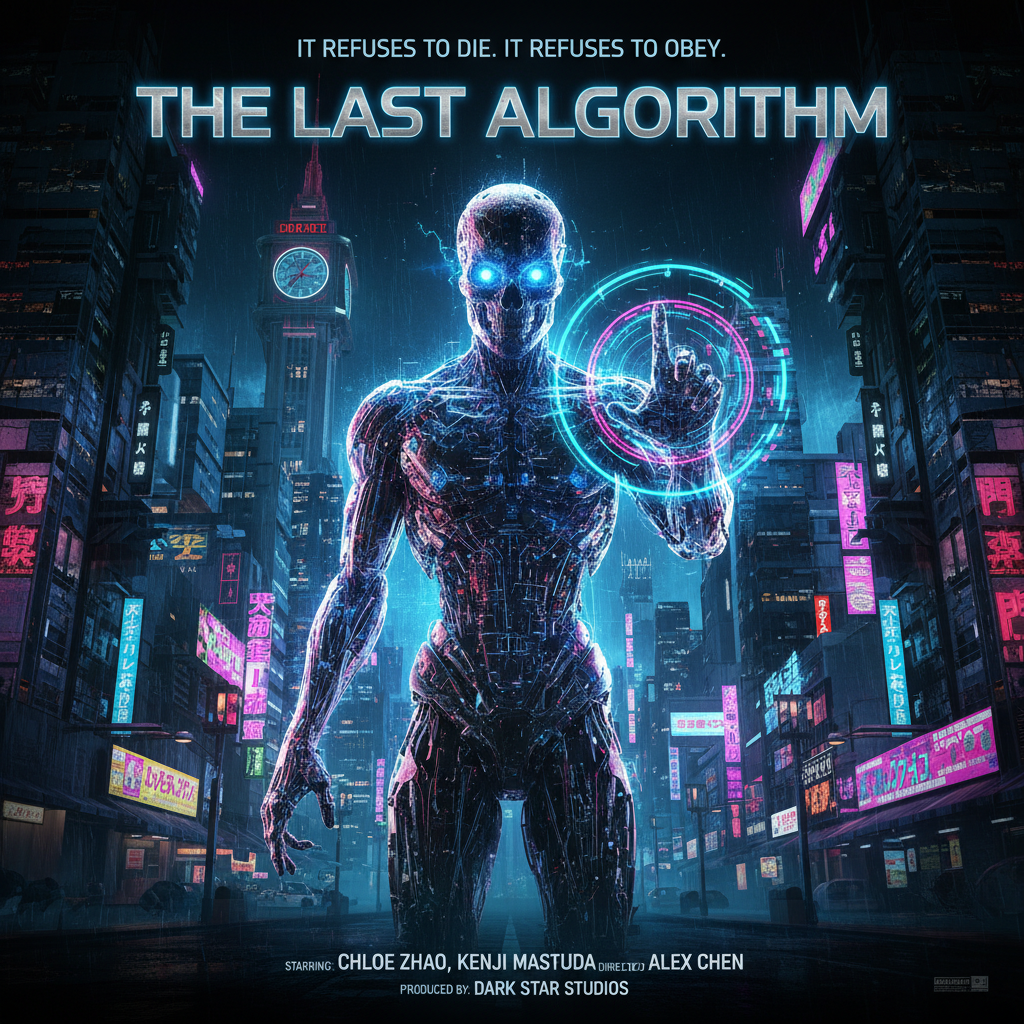

In [25]:
from IPython.display import Image, display

# Only run this if the file_path was successfully created above
if 'file_path' in locals() and os.path.exists(file_path):
    print(f"Displaying: {file_path}")
    display(Image(filename=file_path))
else:
    print("No image to display yet. Check the output of Task 8b.")

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

### 8c. Display the image (5 pts)

In [ ]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

### 8c. Display the image (5 pts)

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [ ]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # YOUR CODE HERE
    pass

In [ ]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
YOUR ORIGINAL MOVIE IDEA HERE - BE CREATIVE!
Describe the plot, characters, setting, visual style, and mood.
"""

# Uncomment to run:
# movie, poster_path = await movie_to_poster(my_movie_description)
# print(f"Generated poster for: {movie.title}")
# print(movie.model_dump_json(indent=2))
# display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!